# 長程-建立模型-平均價格_log-艙等分開

In [1]:
import pandas as pd

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 檢查是否有缺失值
print(data.isnull().sum())

出發日期                     0
出發時間                     0
出發時段                     0
星期                       0
出發機場代號                   0
抵達時間                     0
抵達時段                     0
抵達機場代號                   0
航空公司                     0
航空公司（主航段）              375
航空公司組合                   0
航空聯盟                     0
停靠站數量                    0
停留時間                     0
停留時間_分鐘                  0
飛行時間                     0
飛行時間_分鐘                  0
是否過夜                     0
是否為平日                    0
機型                       2
機型（主航段）                914
機型分類                     0
航班代碼                     0
航班代碼（主航段）              912
艙等                       0
艙等分類                     0
假期                       0
艙等（主航段）                865
停留城市                 27438
第一段飛行時間                915
第二段飛行時間                915
飛行時間兩段分類                 0
平均價格                     0
最低價格                     0
中位數價格                    0
價格變異                     0
隨機購買平均價格             23947
最

**分割經濟艙跟非經濟艙**

In [3]:
# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
non_economy_class_data = data[data["艙等（主航段）"] != "經濟艙"]

# 檢查分割後的數據大小
economy_class_size = economy_class_data.shape[0]
non_economy_class_size = non_economy_class_data.shape[0]

economy_class_size, non_economy_class_size

(48793, 42895)

**特徵重要性圖**


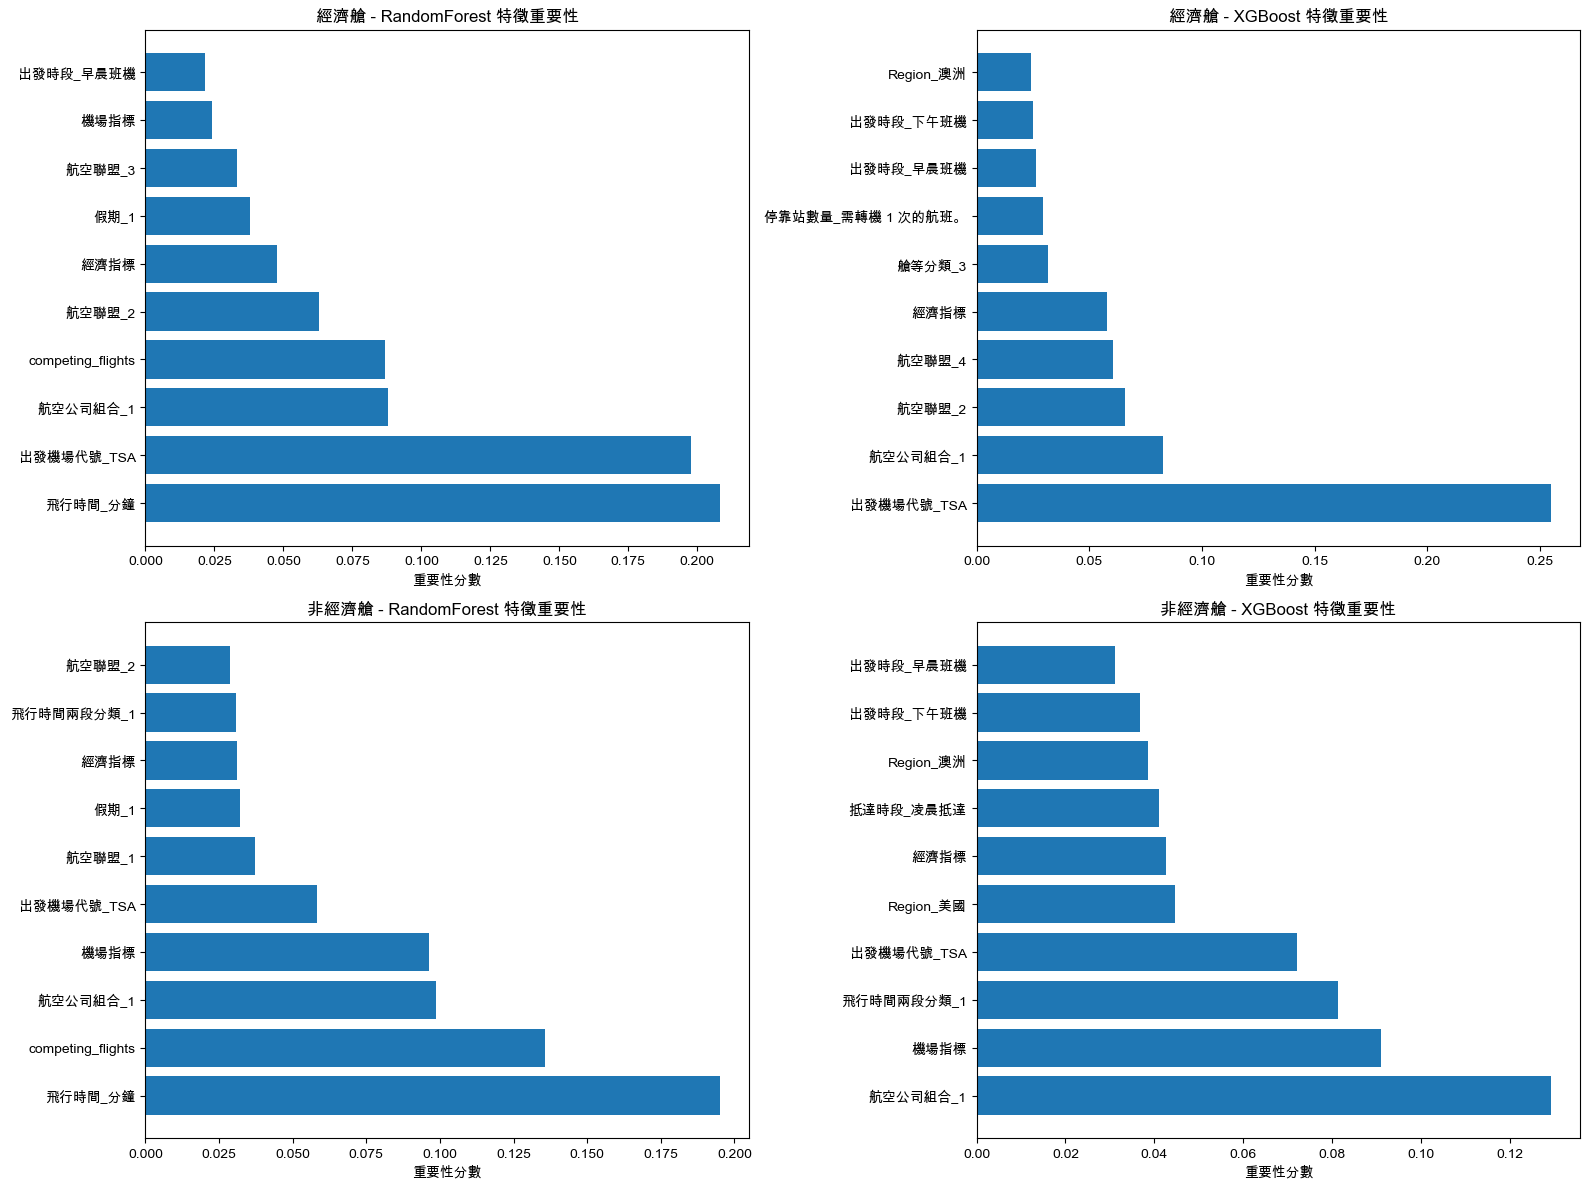

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
non_economy_class_data = data[data["艙等（主航段）"] != "經濟艙"]

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                    '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等分類']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
non_economy_class_data = pd.get_dummies(non_economy_class_data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
non_economy_class_data[num_cols] = scaler.transform(non_economy_class_data[num_cols])

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(non_economy_class_data.columns))
economy_class_data = economy_class_data[common_cols]
non_economy_class_data = non_economy_class_data[common_cols]

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '飛行時間兩段分類_', '艙等分類_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
non_economy_class_data_dummy_cols = [col for col in non_economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
non_economy_class_data_feature_cols = non_economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義自變數與目標變數
X_economy = economy_class_data[economy_class_data_feature_cols]
y_economy = economy_class_data["平均價格_log"]

X_non_economy = non_economy_class_data[non_economy_class_data_feature_cols]
y_non_economy = non_economy_class_data["平均價格_log"]

# 定義函數來訓練模型並獲取特徵重要性
def get_feature_importance(X, y):
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
    rf_model.fit(X, y)
    rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=123, n_jobs=-1, verbosity=0)
    xgb_model.fit(X, y)
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    return rf_importance, xgb_importance

# 訓練並獲取特徵重要性
rf_importance_economy, xgb_importance_economy = get_feature_importance(X_economy, y_economy)
rf_importance_non_economy, xgb_importance_non_economy = get_feature_importance(X_non_economy, y_non_economy)

# 繪製特徵重要性圖
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 經濟艙
axes[0,0].barh(rf_importance_economy.index[:10], rf_importance_economy.values[:10])
axes[0,0].set_title("經濟艙 - RandomForest 特徵重要性")
axes[0,0].set_xlabel("重要性分數")

axes[0,1].barh(xgb_importance_economy.index[:10], xgb_importance_economy.values[:10])
axes[0,1].set_title("經濟艙 - XGBoost 特徵重要性")
axes[0,1].set_xlabel("重要性分數")

axes[1,0].barh(rf_importance_non_economy.index[:10], rf_importance_non_economy.values[:10])
axes[1,0].set_title("非經濟艙 - RandomForest 特徵重要性")
axes[1,0].set_xlabel("重要性分數")

axes[1,1].barh(xgb_importance_non_economy.index[:10], xgb_importance_non_economy.values[:10])
axes[1,1].set_title("非經濟艙 - XGBoost 特徵重要性")
axes[1,1].set_xlabel("重要性分數")

plt.tight_layout()
plt.show()

**5次平均**

In [6]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
non_economy_class_data = data[data["艙等（主航段）"] != "經濟艙"]

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                    '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等分類']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
non_economy_class_data = pd.get_dummies(non_economy_class_data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
non_economy_class_data[num_cols] = scaler.transform(non_economy_class_data[num_cols])

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(non_economy_class_data.columns))
economy_class_data = economy_class_data[common_cols]
non_economy_class_data = non_economy_class_data[common_cols]

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '飛行時間兩段分類_', '艙等分類_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
non_economy_class_data_dummy_cols = [col for col in non_economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
non_economy_class_data_feature_cols = non_economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}

    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    return cabin_type, result

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行運算經濟艙與非經濟艙
all_results_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, economy_class_data[economy_class_data_feature_cols], economy_class_data["平均價格_log"], "經濟艙") for seed in seeds)
all_results_non_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, non_economy_class_data[non_economy_class_data_feature_cols], non_economy_class_data["平均價格_log"], "非經濟艙") for seed in seeds)

# 解析結果
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }

    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

    avg_results = {}
    for model, metrics in results.items():
        avg_results[model] = {
            'Average MSE': np.mean(metrics['MSE']),
            'Average R2': np.mean(metrics['R2']),
            'Average RMSE': np.mean(metrics['RMSE']),
            'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
        }
    
    print(f"\n{cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        print(f"  MSE = {scores['Average MSE']:.4f}")
        print(f"  R^2 = {scores['Average R2']:.4f}")
        print(f"  RMSE = {scores['Average RMSE']:.4f}")
        print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

# 顯示結果
process_results(all_results_economy, "經濟艙")
process_results(all_results_non_economy, "非經濟艙")


經濟艙 - Average Performance over 5 runs:
RandomForest:
  MSE = 0.0350
  R^2 = 0.8867
  RMSE = 0.1871
  Adjusted R^2 = 0.8864
SVR:
  MSE = 0.0732
  R^2 = 0.7631
  RMSE = 0.2706
  Adjusted R^2 = 0.7625
XGBoost:
  MSE = 0.0851
  R^2 = 0.7245
  RMSE = 0.2917
  Adjusted R^2 = 0.7239

非經濟艙 - Average Performance over 5 runs:
RandomForest:
  MSE = 0.0549
  R^2 = 0.6625
  RMSE = 0.2343
  Adjusted R^2 = 0.6616
SVR:
  MSE = 0.0624
  R^2 = 0.6168
  RMSE = 0.2497
  Adjusted R^2 = 0.6158
XGBoost:
  MSE = 0.0633
  R^2 = 0.6112
  RMSE = 0.2515
  Adjusted R^2 = 0.6101


**30次平均**

In [7]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
non_economy_class_data = data[data["艙等（主航段）"] != "經濟艙"]

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                    '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等分類']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
non_economy_class_data = pd.get_dummies(non_economy_class_data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
non_economy_class_data[num_cols] = scaler.transform(non_economy_class_data[num_cols])

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(non_economy_class_data.columns))
economy_class_data = economy_class_data[common_cols]
non_economy_class_data = non_economy_class_data[common_cols]

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '飛行時間兩段分類_', '艙等分類_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
non_economy_class_data_dummy_cols = [col for col in non_economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
non_economy_class_data_feature_cols = non_economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}

    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=1)  # 避免資源過載
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=1)  # 避免資源過載
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    return cabin_type, result

# 設定運行次數（30 次）與隨機種子列表
n_runs = 30
seeds = list(range(n_runs))

# 平行運算經濟艙與非經濟艙
all_results_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, economy_class_data[economy_class_data_feature_cols], economy_class_data["平均價格_log"], "經濟艙") for seed in seeds)
all_results_non_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, non_economy_class_data[non_economy_class_data_feature_cols], non_economy_class_data["平均價格_log"], "非經濟艙") for seed in seeds)

# 統計結果
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }

    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

    avg_results = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in results.items()}
    
    print(f"\n{cabin_type} - Average Performance over {n_runs} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        for metric, value in scores.items():
            print(f"  {metric} = {value:.4f}")

# 顯示結果
process_results(all_results_economy, "經濟艙")
process_results(all_results_non_economy, "非經濟艙")


經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0352
  R2 = 0.8858
  RMSE = 0.1876
  Adjusted_R2 = 0.8855
SVR:
  MSE = 0.0714
  R2 = 0.7685
  RMSE = 0.2672
  Adjusted_R2 = 0.7680
XGBoost:
  MSE = 0.0833
  R2 = 0.7299
  RMSE = 0.2886
  Adjusted_R2 = 0.7293

非經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0544
  R2 = 0.6621
  RMSE = 0.2331
  Adjusted_R2 = 0.6611
SVR:
  MSE = 0.0603
  R2 = 0.6252
  RMSE = 0.2455
  Adjusted_R2 = 0.6242
XGBoost:
  MSE = 0.0624
  R2 = 0.6121
  RMSE = 0.2498
  Adjusted_R2 = 0.6111


**視覺化**

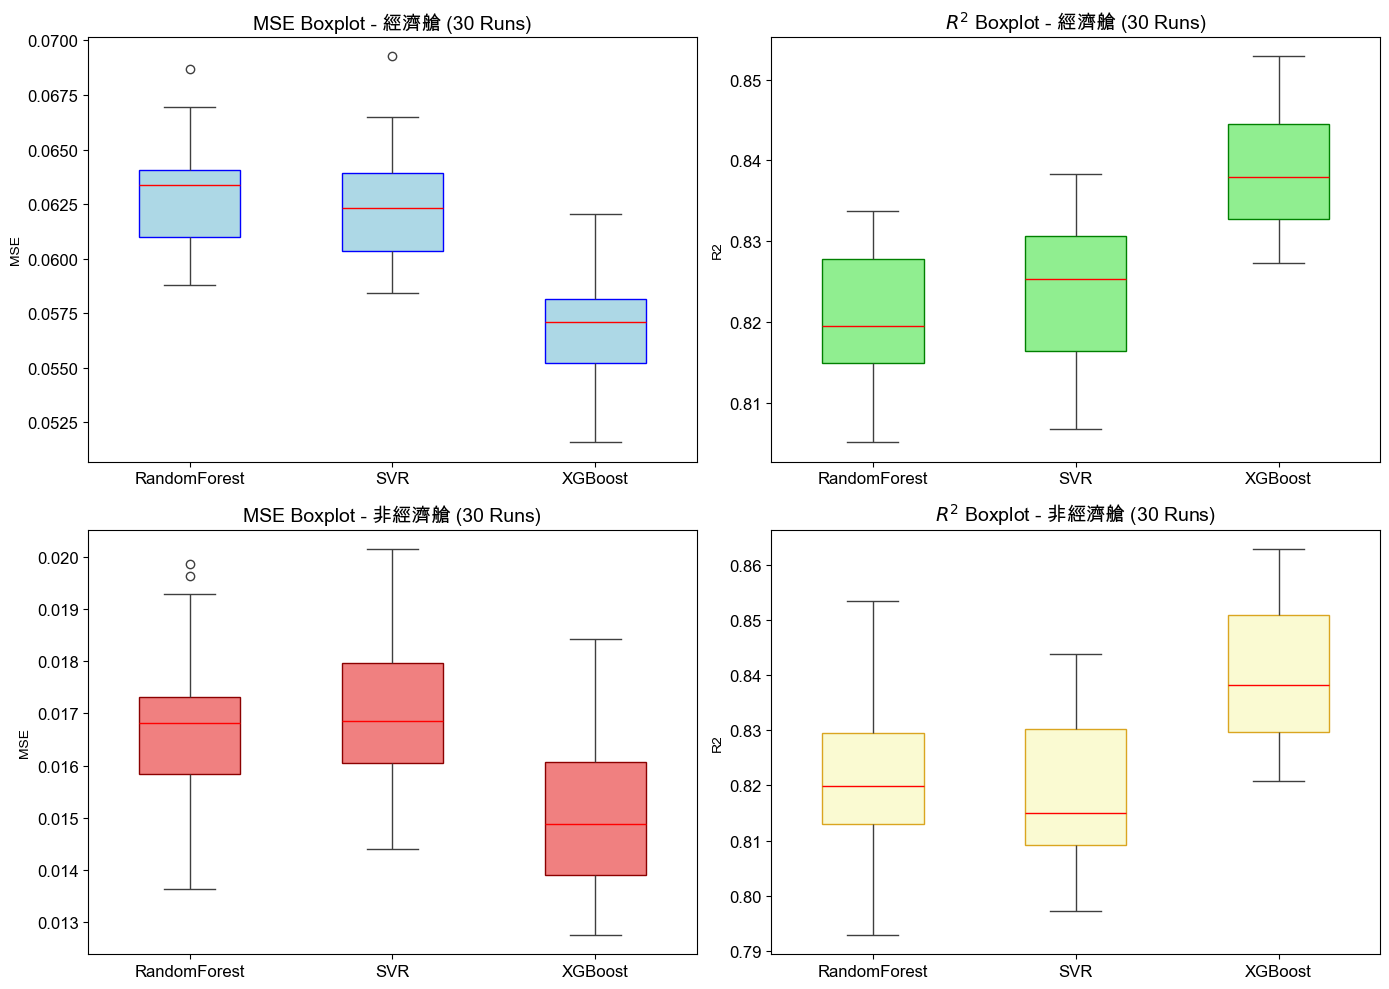

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 只取出 results（不包含 cabin_type）
all_results_economy_cleaned = [res[1] for res in all_results_economy]  
all_results_non_economy_cleaned = [res[1] for res in all_results_non_economy]

# 轉換為 DataFrame
mse_df_economy = pd.DataFrame({model: [res[model]['MSE'] for res in all_results_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})
r2_df_economy = pd.DataFrame({model: [res[model]['R2'] for res in all_results_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})

mse_df_non_economy = pd.DataFrame({model: [res[model]['MSE'] for res in all_results_non_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})
r2_df_non_economy = pd.DataFrame({model: [res[model]['R2'] for res in all_results_non_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})

# 使用 melt 轉換為長格式
mse_long_economy = mse_df_economy.melt(var_name='Model', value_name='MSE')
r2_long_economy = r2_df_economy.melt(var_name='Model', value_name='R2')

mse_long_non_economy = mse_df_non_economy.melt(var_name='Model', value_name='MSE')
r2_long_non_economy = r2_df_non_economy.melt(var_name='Model', value_name='R2')

# 建立 2x2 子圖
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 經濟艙 MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long_economy, ax=axes[0, 0],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightblue', 'edgecolor': 'blue'},
            medianprops={'color': 'red'})
axes[0, 0].set_title('MSE Boxplot - 經濟艙 (30 Runs)', fontsize=14)
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(labelsize=12)

# 經濟艙 R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long_economy, ax=axes[0, 1],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightgreen', 'edgecolor': 'green'},
            medianprops={'color': 'red'})
axes[0, 1].set_title('$R^2$ Boxplot - 經濟艙 (30 Runs)', fontsize=14)
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(labelsize=12)

# 非經濟艙 MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long_non_economy, ax=axes[1, 0],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightcoral', 'edgecolor': 'darkred'},
            medianprops={'color': 'red'})
axes[1, 0].set_title('MSE Boxplot - 非經濟艙 (30 Runs)', fontsize=14)
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(labelsize=12)

# 非經濟艙 R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long_non_economy, ax=axes[1, 1],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightgoldenrodyellow', 'edgecolor': 'goldenrod'},
            medianprops={'color': 'red'})
axes[1, 1].set_title('$R^2$ Boxplot - 非經濟艙 (30 Runs)', fontsize=14)
axes[1, 1].set_xlabel('')
axes[1, 1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()